## 卷积神经网络：猫狗大战

### 第一步:导入数据集

kaggle狗猫大战地址为:[kaggle](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data)。

登录kaggle，在My Account中创建自己的Token

下方代码实现将kaggle数据集下载到codelab中


In [1]:
# 将kaggle的数据集直接下载到codelab中
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"填上你自己的username","key":"填上你自己的key"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

 94% 256M/271M [00:01<00:00, 191MB/s]
100% 271M/271M [00:01<00:00, 200MB/s]
 96% 524M/544M [00:02<00:00, 236MB/s]
100% 544M/544M [00:02<00:00, 231MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 95.9MB/s]


In [0]:
# 将文件解压
! unzip ./train.zip 
! unzip ./test.zip  

总之，训练集有25000张图片，猫狗各占一半。测试集有12500张，没有标定是猫还是狗

### 第二步：加载数据集

In [3]:
# 导入开发需要的库
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import numpy as np
from tqdm import tqdm
import cv2

Using TensorFlow backend.


In [4]:
np.random.seed(2019)

n = 25000
X = np.zeros((n, 224, 224, 3), dtype=np.uint8)
y = np.zeros((n, 1), dtype=np.uint8)

for i in tqdm(range(n//2)):
  X[i] = cv2.resize(cv2.imread('train/cat.%d.jpg' % i), (224, 224))
  X[i+n//2] = cv2.resize(cv2.imread('train/dog.%d.jpg' % i), (224, 224))
  
y[n//2:] = 1

100%|██████████| 12500/12500 [00:51<00:00, 240.94it/s]


In [0]:
# 分为训练集和验证集
from sklearn.model_selection import train_test_split
X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size=0.2)

### 第三步:迁移模型

In [6]:
base_model = ResNet50(input_tensor=Input((224,224,3)),weights="imagenet",include_top=False)

for layers in base_model.layers:
  layers.trainable = False
  
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.25)(x)
x = Dense(1,activation="sigmoid")(x)

model = Model(base_model.input,x)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


W0812 07:26:07.502825 140432049747840 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
 model.compile(optimizer="adadelta",
               loss="binary_crossentropy",
               metrics=["accuracy"])

W0812 07:26:09.080481 140432049747840 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0812 07:26:09.110014 140432049747840 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
model.fit(X_train,
          y_train,
          batch_size=16,
          epochs=5,
          validation_data=(X_valid,y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 109s 5ms/step - loss: 0.1172 - acc: 0.9544 - val_loss: 0.0607 - val_acc: 0.9792
Epoch 2/5
20000/20000 [==============================] - 103s 5ms/step - loss: 0.0829 - acc: 0.9680 - val_loss: 0.0721 - val_acc: 0.9768
Epoch 3/5
20000/20000 [==============================] - 104s 5ms/step - loss: 0.0792 - acc: 0.9697 - val_loss: 0.0721 - val_acc: 0.9790
Epoch 4/5
20000/20000 [==============================] - 104s 5ms/step - loss: 0.0722 - acc: 0.9731 - val_loss: 0.0755 - val_acc: 0.9782
Epoch 5/5
20000/20000 [==============================] - 103s 5ms/step - loss: 0.0745 - acc: 0.9729 - val_loss: 0.0680 - val_acc: 0.9792


### 第四步：可视化模型


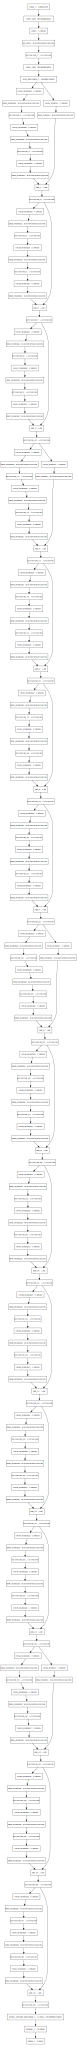

In [9]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

### 第五步:CAM 可视化

http://cnnlocalization.csail.mit.edu/

![](http://cnnlocalization.csail.mit.edu/framework.jpg)

$cam = (P-0.5)*w*output$

* cam: 类激活图 7\*7
* P: 猫狗概率
* output: 卷积层的输出 2048\*1
* w: 卷积核的权重 7\*7\*2048

In [16]:
import matplotlib.pyplot as plt
import random
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 14))
for i in range(16):
    plt.subplot(4, 4, i+1)
    img = cv2.imread('test/%d.jpg' % random.randint(1, 12500))
    img = cv2.resize(img, (224, 224))
    x = img.copy()
    x.astype(np.float32)
    out, prediction = model2.predict(np.expand_dims(x, axis=0))

    prediction = prediction[0]
    out = out[0]

    if prediction < 0.5:
        plt.title('cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title('dog %.2f%%' % (prediction*100))

    cam = (prediction - 0.5) * np.matmul(out, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8

    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0

    out = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)

    plt.axis('off')
    plt.imshow(out[:,:,::-1])

Output hidden; open in https://colab.research.google.com to view.

### 第六步:微调
http://keras-cn.readthedocs.io/en/latest/blog/image_classification_using_very_little_data/

In [0]:
for layer in model.layers[140:]:
    layer.trainable = True

In [18]:
model.fit(X_train, y_train, batch_size=16, epochs=5, validation_data=(X_valid, y_valid))

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
   32/20000 [..............................] - ETA: 1:47 - loss: 0.0309 - acc: 1.0000

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


20000/20000 [==============================] - 104s 5ms/step - loss: 0.0738 - acc: 0.9724 - val_loss: 0.0752 - val_acc: 0.9786
Epoch 2/5
20000/20000 [==============================] - 104s 5ms/step - loss: 0.0784 - acc: 0.9716 - val_loss: 0.0842 - val_acc: 0.9768
Epoch 3/5
20000/20000 [==============================] - 104s 5ms/step - loss: 0.0700 - acc: 0.9731 - val_loss: 0.0931 - val_acc: 0.9758
Epoch 4/5
20000/20000 [==============================] - 104s 5ms/step - loss: 0.0710 - acc: 0.9730 - val_loss: 0.0820 - val_acc: 0.9784
Epoch 5/5
20000/20000 [==============================] - 103s 5ms/step - loss: 0.0689 - acc: 0.9741 - val_loss: 0.0978 - val_acc: 0.9742


### 第七步：模型保存

In [0]:
model.save_weights("resnet.h5")